In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import yfinance as yf
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import plotly as plotly
import plotly.io as plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from pandas.plotting import autocorrelation_plot
import itertools
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler  # Import MinMaxScaler


from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [2]:
warnings.filterwarnings('ignore')

In [3]:
 
ticker = yf.Ticker("MSFT")

In [4]:

start_date = "2016-06-14"

In [5]:

df = ticker.history(start=start_date, end=None)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-06-14 00:00:00-04:00,44.892183,45.072109,44.595299,44.829208,42577100,0.0,0.0
2016-06-15 00:00:00-04:00,44.784234,45.090113,44.703266,44.703266,33757600,0.0,0.0
2016-06-16 00:00:00-04:00,44.550316,45.404977,44.541317,45.333004,31188600,0.0,0.0
2016-06-17 00:00:00-04:00,45.351005,45.368998,44.820215,45.099106,45710500,0.0,0.0
2016-06-20 00:00:00-04:00,45.557916,45.728851,45.009134,45.045120,35607900,0.0,0.0


In [6]:
selected_columns = ['Close']
selected_data = df[selected_columns]

In [7]:
# Convert 'Date' to datetime and set it as the index
#selected_data.loc[:, 'Date'] = pd.to_datetime(selected_data['Date'])
#selected_data.set_index('Date', inplace=True)

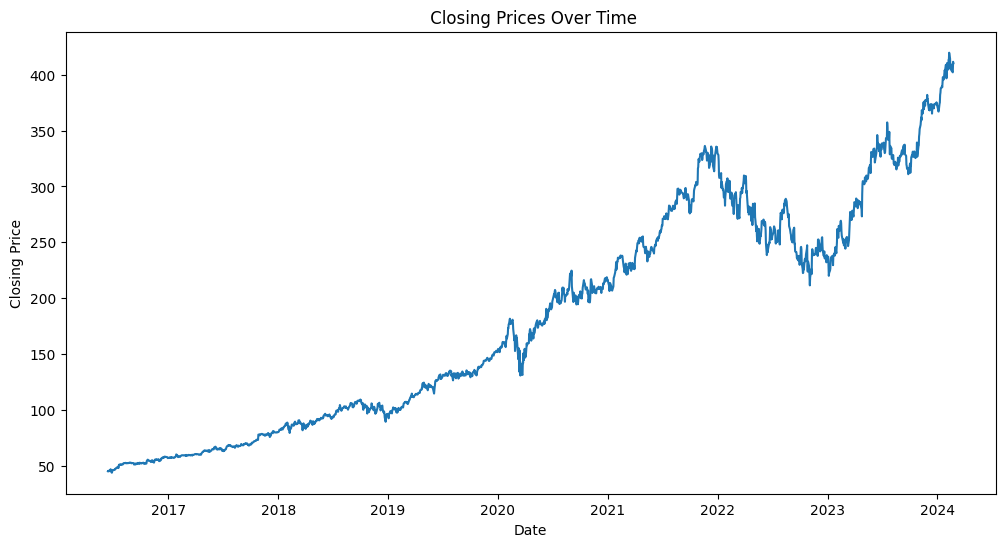

In [8]:

plt.figure(figsize=(12, 6))
plt.plot(df['Close'])
plt.title(' Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

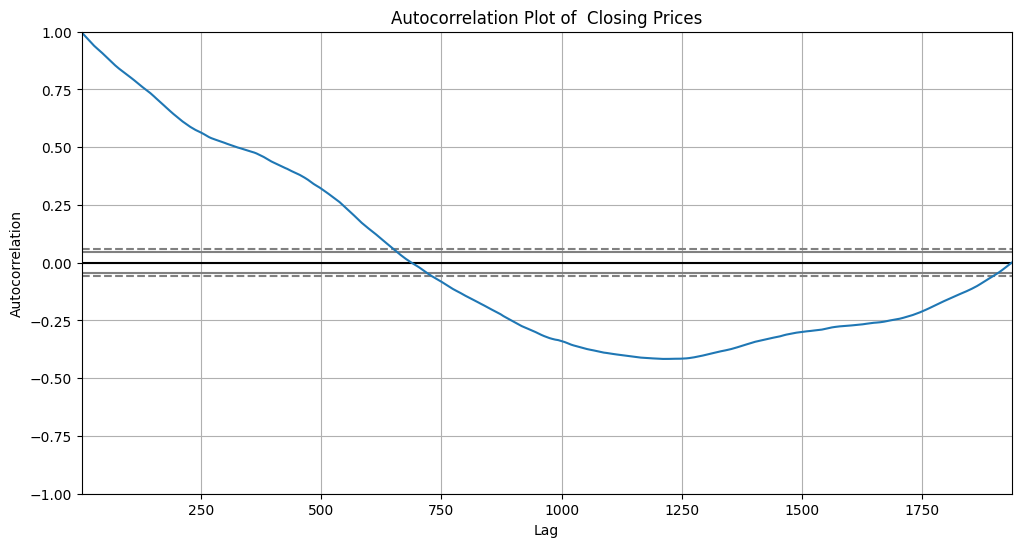

In [9]:

plt.figure(figsize=(12, 6))
autocorrelation_plot(df['Close'])
plt.title('Autocorrelation Plot of  Closing Prices')
plt.show() 

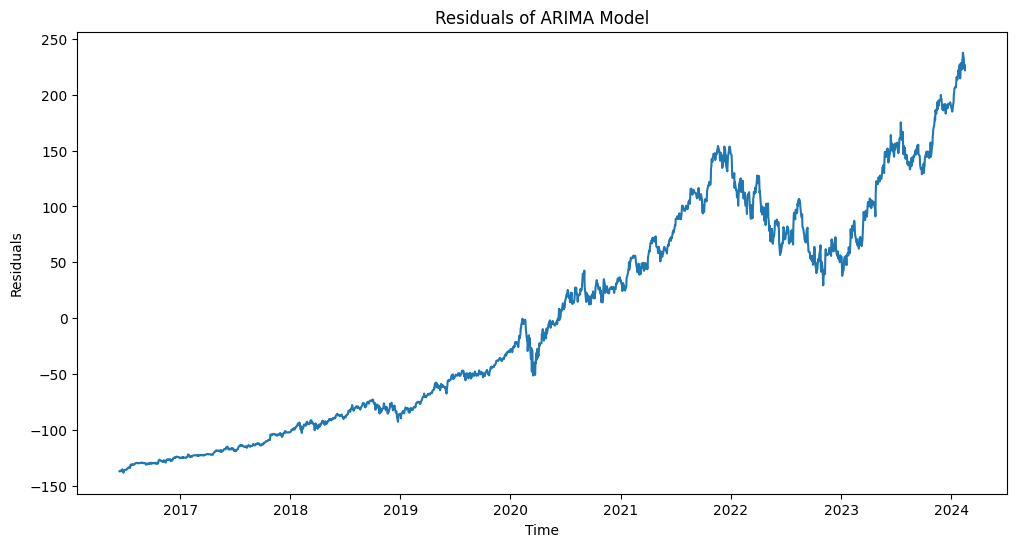

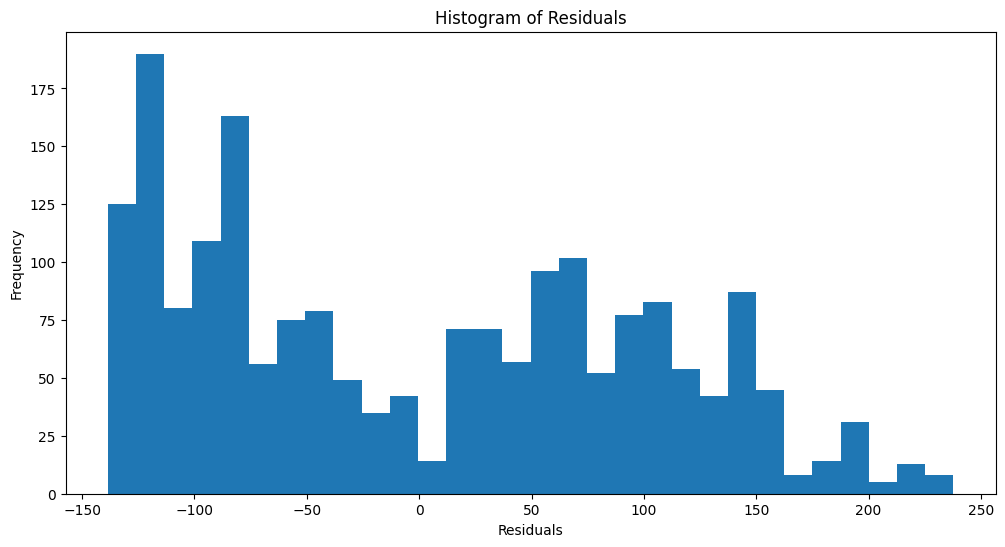

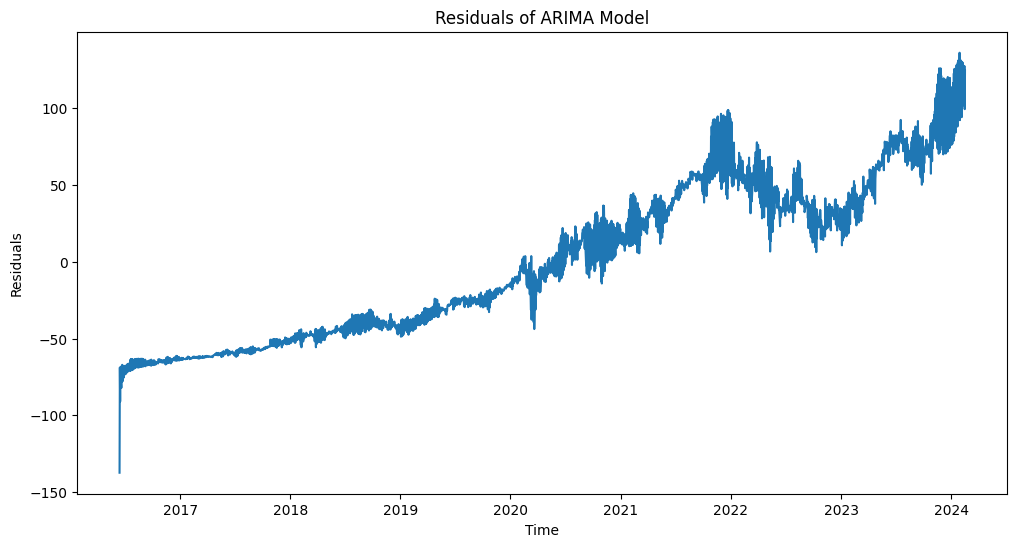

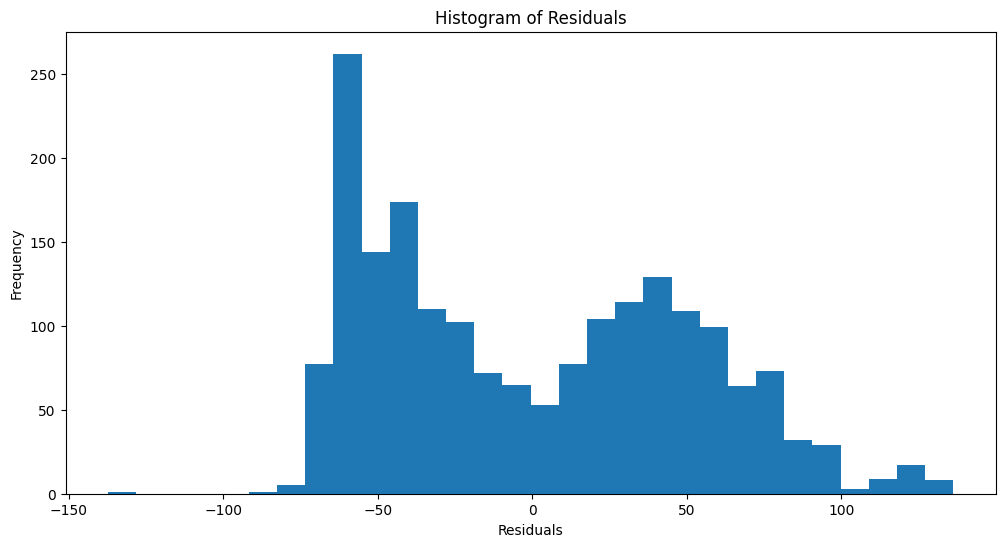

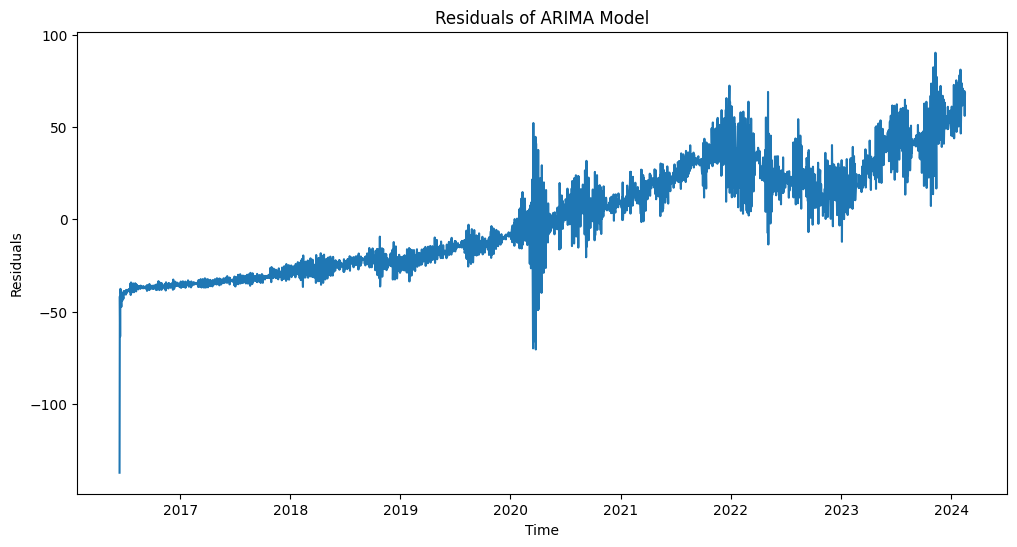

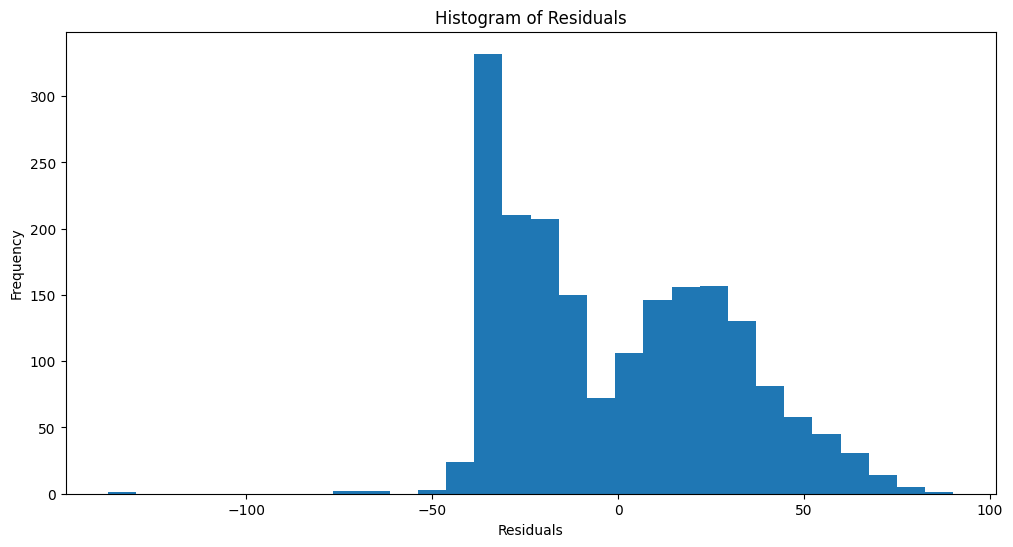

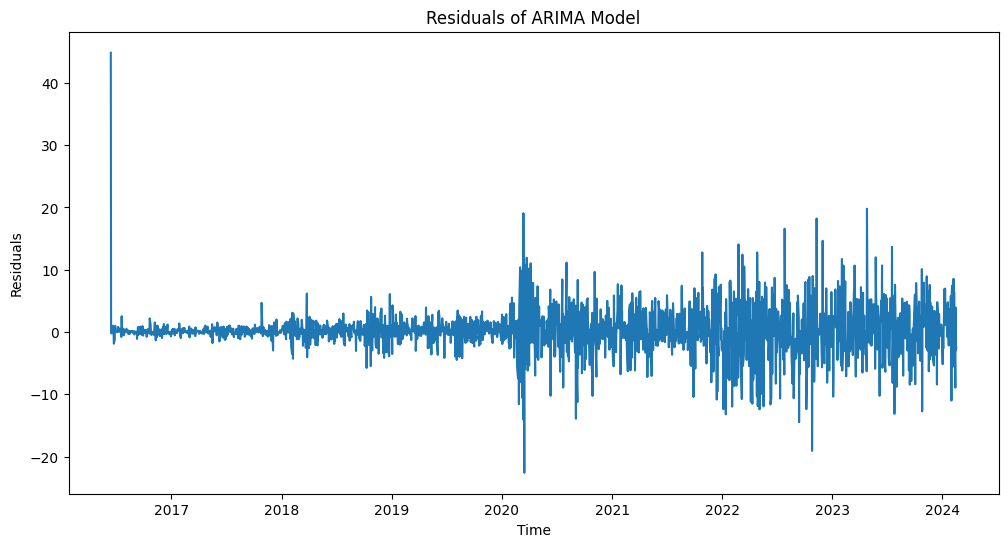

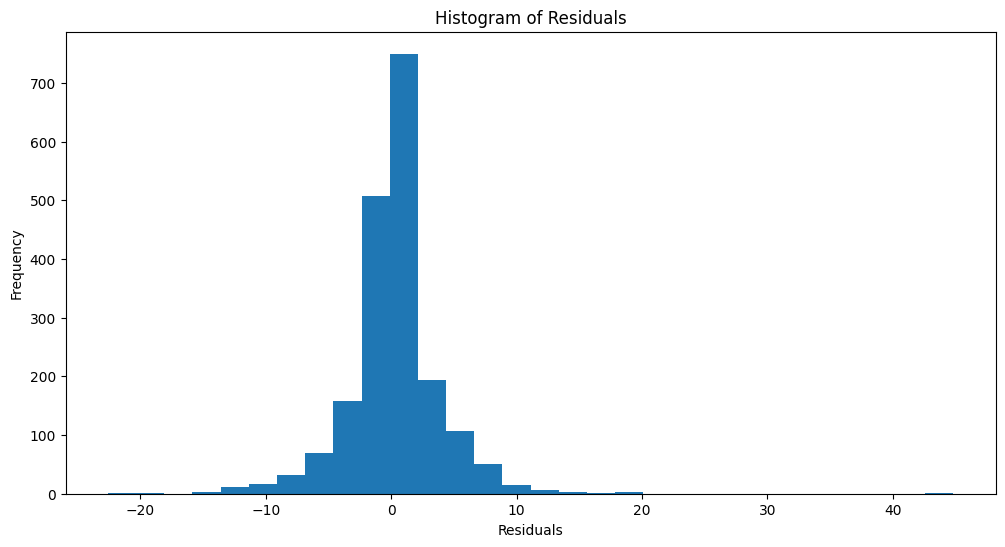

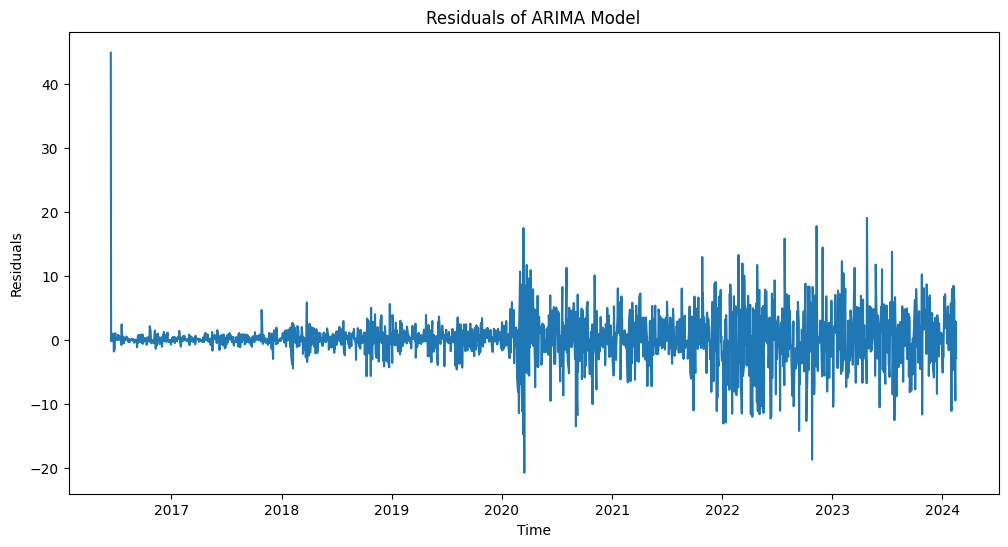

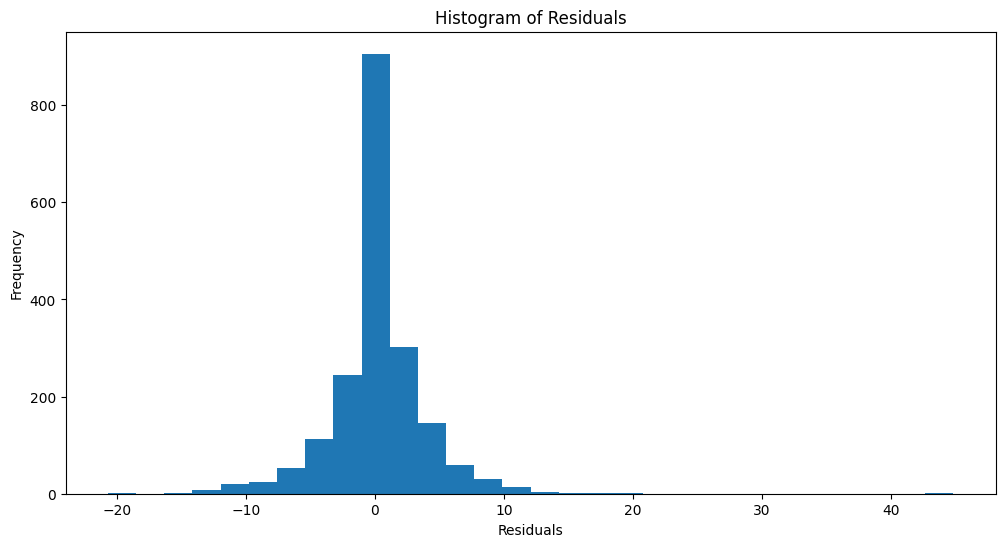

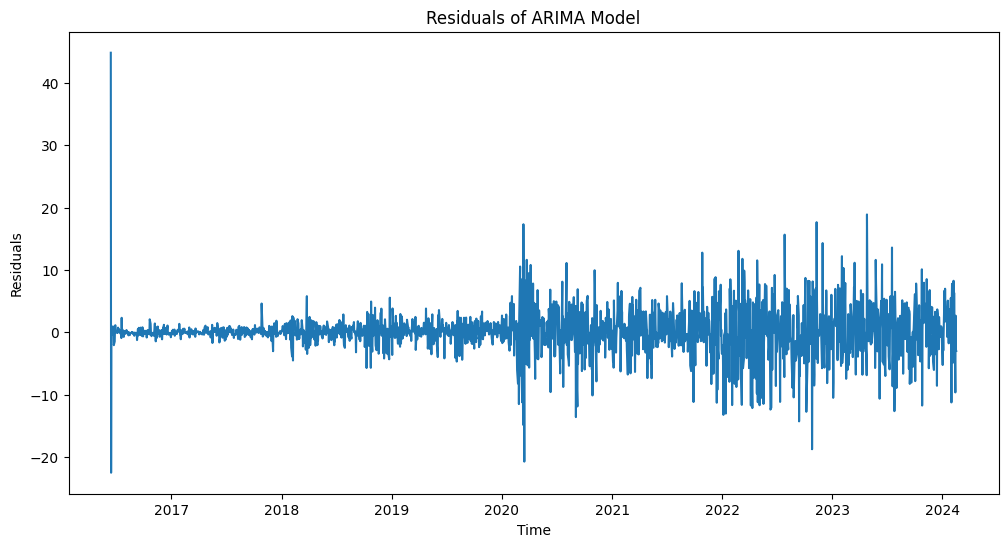

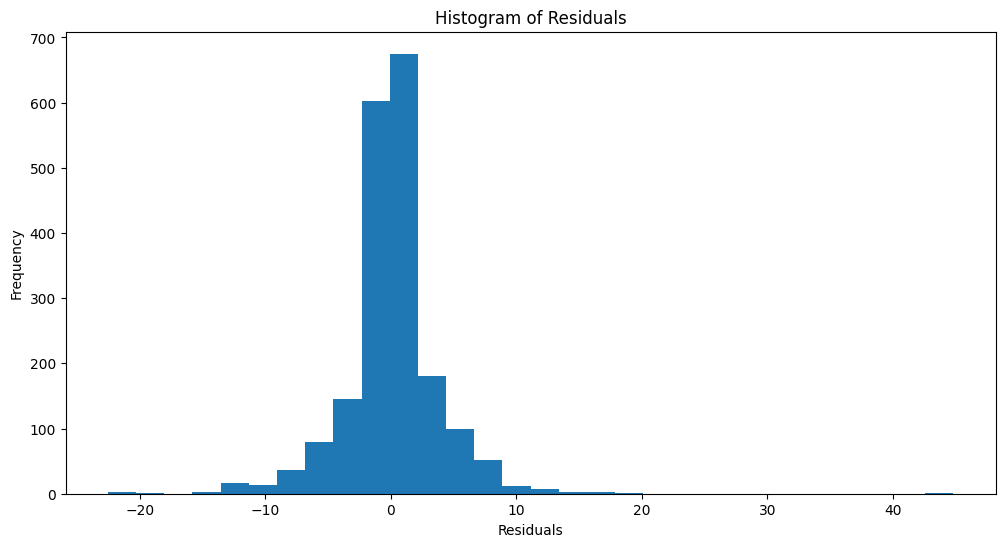

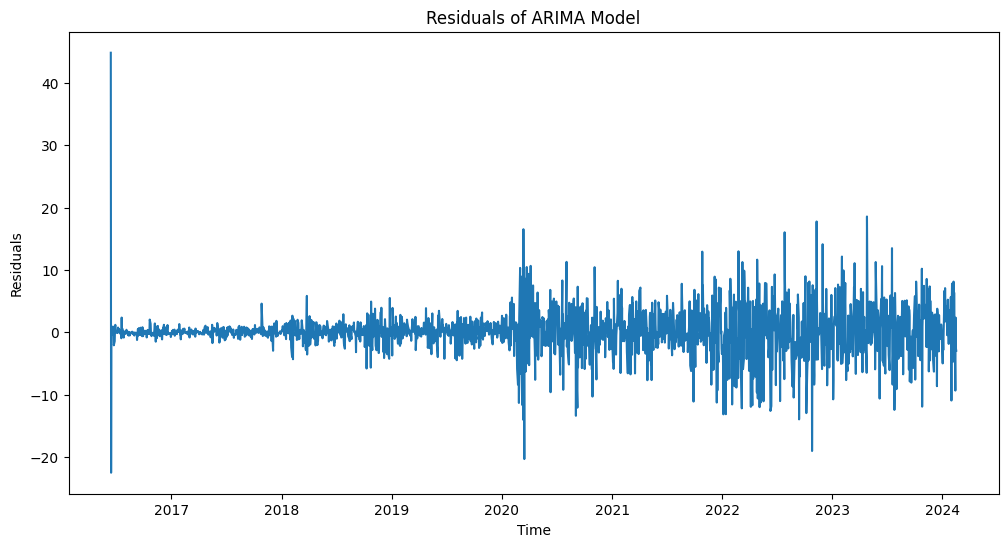

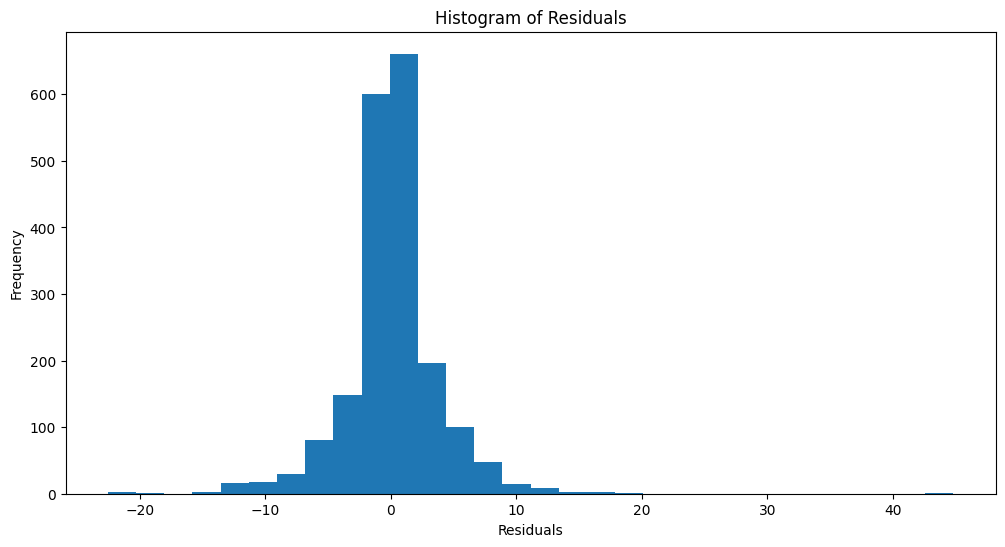

Best AIC: 10400.47546696732
Best (p, d, q): (2, 2, 2)


In [10]:
# Define the range of values for p, d, and q
p = d = q = range(0, 3)

# Generate all possible combinations of p, d, q
pdq = list(itertools.product(p, d, q))

# Grid search for the best ARIMA model
best_aic = float("inf")
best_pdq = None

for params in pdq:
    try:
        model = sm.tsa.ARIMA(df['Close'], order=params)
        results = model.fit()
        aic = results.aic
        if aic < best_aic:
            best_aic = aic
            best_pdq = params
            # Get residuals and plot
            residuals = results.resid
            plt.figure(figsize=(12, 6))
            plt.plot(residuals)
            plt.title('Residuals of ARIMA Model')
            plt.xlabel('Time')
            plt.ylabel('Residuals')
            plt.show()

            plt.figure(figsize=(12, 6))
            plt.hist(residuals, bins=30)
            plt.title('Histogram of Residuals')
            plt.xlabel('Residuals')
            plt.ylabel('Frequency')
            plt.show()
    except:
        continue

print(f"Best AIC: {best_aic}")
print(f"Best (p, d, q): {best_pdq}")

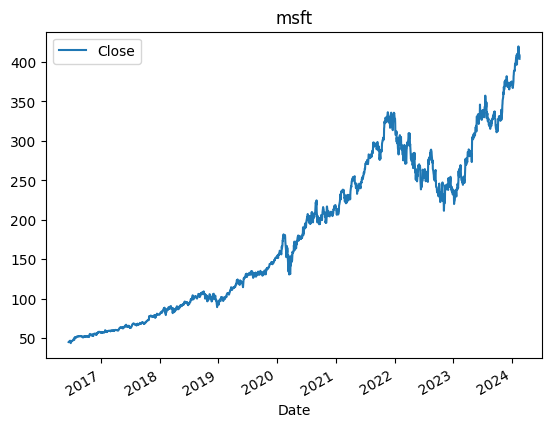

In [11]:
df[['Close']].plot()
plt.title("msft")
plt.show()

Text(0.5, 1.0, ' Autocorrelation plot')

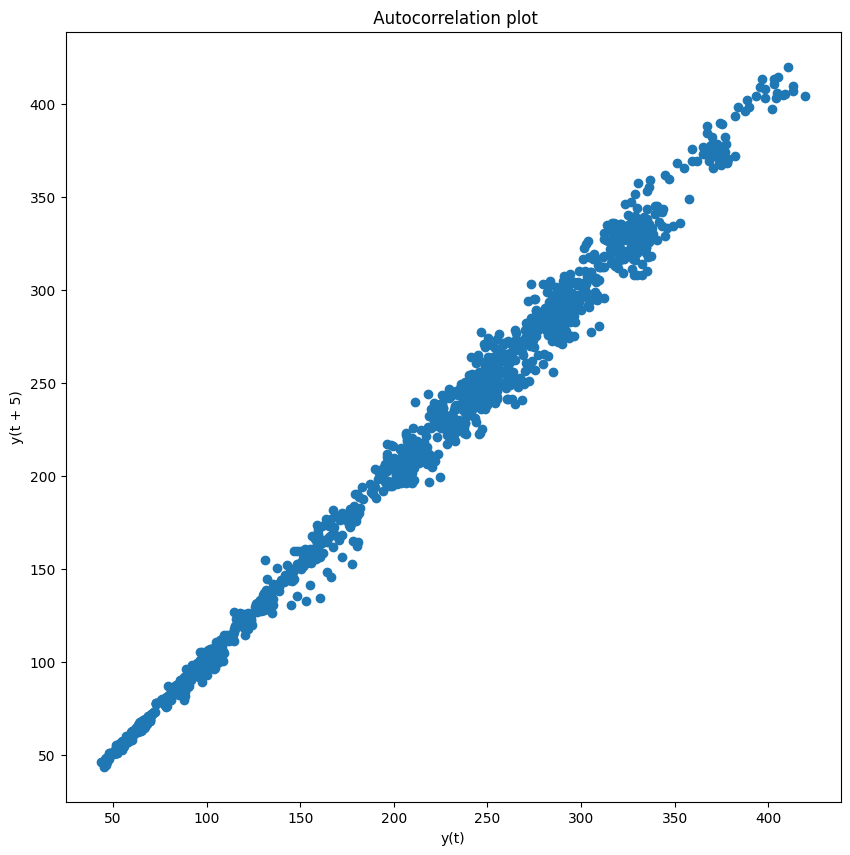

In [12]:
plt.figure(figsize=(10,10))
lag_plot(df['Close'], lag=5)
plt.title(' Autocorrelation plot')

In [13]:
train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]

In [14]:

train_ar = train_data['Close'].values
test_ar = test_data['Close'].values

In [15]:

scaler = MinMaxScaler()
train_ar_scaled = scaler.fit_transform(train_ar.reshape(-1, 1)).flatten()
test_ar_scaled = scaler.transform(test_ar.reshape(-1, 1)).flatten()

In [16]:
# Fit ARIMA model
history = [x for x in train_ar_scaled]
predictions_scaled = list()

for t in range(len(test_ar_scaled)):
    model = ARIMA(history, order=(2, 2, 2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions_scaled.append(yhat)
    obs = test_ar_scaled[t]
    history.append(obs)

In [17]:

predictions = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1)).flatten()


In [18]:

test_ar_original_scale = scaler.inverse_transform(test_ar_scaled.reshape(-1, 1)).flatten()

In [19]:

rolling_mse = mean_squared_error(test_ar_original_scale, predictions)
print('Test MSE on Original Scale: %.3f' % rolling_mse)
rmse = np.sqrt(mean_squared_error(test_ar_original_scale, predictions))
print('RMSE on Original Scale: %.3f' % rmse)
mae = np.mean(np.abs(predictions - test_ar_original_scale))
print('MAE on Original Scale: %.3f' % mae)
mape = np.mean(np.abs((test_ar_original_scale - predictions) / test_ar_original_scale)) * 100
print('MAPE on Original Scale: %.3f%%' % mape)
correct_sign_percentage = (np.sign(predictions[1:] - predictions[:-1]) == np.sign(test_ar_original_scale[1:] - test_ar_original_scale[:-1])).mean() * 100
print('Percentage of Correct Sign Predictions: %.2f%%' % correct_sign_percentage)

Test MSE on Original Scale: 24.719
RMSE on Original Scale: 4.972
MAE on Original Scale: 3.848
MAPE on Original Scale: 1.331%
Percentage of Correct Sign Predictions: 52.33%


In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_data.index, y=test_data['Close'], name='Close'))
fig.add_trace(go.Scatter(x=test_data.index, y=predictions, name='Forecast_Rolling_ARIMA'))
fig.show()